# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error

# Loading The Data

In [2]:
# loading the dataset from the csv file
df = pd.read_csv('../Data/Preprocessed_data.csv')

# Data Overview

In [3]:
print("First Five Rows:\n")
df.head()

First Five Rows:



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S


The data has columns:
- Survival: Whether a passenger survived or not (0 or 1)
- Pclass: The socio-ecomonic class
    - Upper: 1
    - Middle: 2
    - Lower: 3
- Sex: Gender of the passenger (Male or Female)
- Age: Age in years (Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5)
- SibSp: Number of siblings / spouses aboard the Titanic
- Parch: Number of parents / children aboard the Titanic
- Fare: Passenger fare
- Embarked: Port of Embarkation
    - C: Cherbourg
    - Q: Queenstown
    - S: Southampton


In [4]:
print("Number of Rows and Columns:\n")
df.shape

Number of Rows and Columns:



(891, 9)

- There are 891 rows and 9 columns

In [5]:
print("Details of Columns Regarding Data Type, Missing Value, and Entries\n")
df.info()

Details of Columns Regarding Data Type, Missing Value, and Entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 62.8+ KB


- numerical data type = Survived, Pclass, Age, SibSp, Parch, Fare 
- Object data type = Name, Sex, TIcket, Cabin, Embarked
- Sex, Embarked to be changed into category type from object type. 


In [6]:
print("Summary Statistics:\n")
df.describe()

Summary Statistics:



,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.345679,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.028212,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- This is a summary statistics of the numerical columns in the dataset.
- #The mean of the SURVIVED col shows 38% survival rate. Roughly 1 in 3 survive the Titanic

In [7]:
print("Missing Values Percentage Across Columns:\n")
df.isnull().sum()/len(df)*100

Missing Values Percentage Across Columns:



Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

- No missing values
  

In [8]:
sum(df.duplicated())

0

In [9]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Columns:", numerical_cols.tolist())

Numerical Columns: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [10]:
object_cols = df.select_dtypes(include=['object']).columns
print("Object Columns:", object_cols.tolist())

Object Columns: ['Name', 'Sex', 'Embarked']


In [11]:
#lets change sex and embarked to categorical data
# Let's convert them into categorical features to save some memory. 
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')



In [12]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S


# Feature Engineering

## Transforming Name 
- The name column can be used to determine sex (with words like Miss, Mrs, Mr)
- Might be useful to determine passenger age group like child, middle age, etc.
- Can be used to group into families
- Can be used to determine the relationship between Survived columns. 

### Extracting Titles from Names and Adding as a Separate Column


In [13]:
df['Title']=df['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]

In [14]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [41]:
#Grouping titles into catgegories
df['Title'] = df['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [16]:
df['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

### VIsualizing Title Column

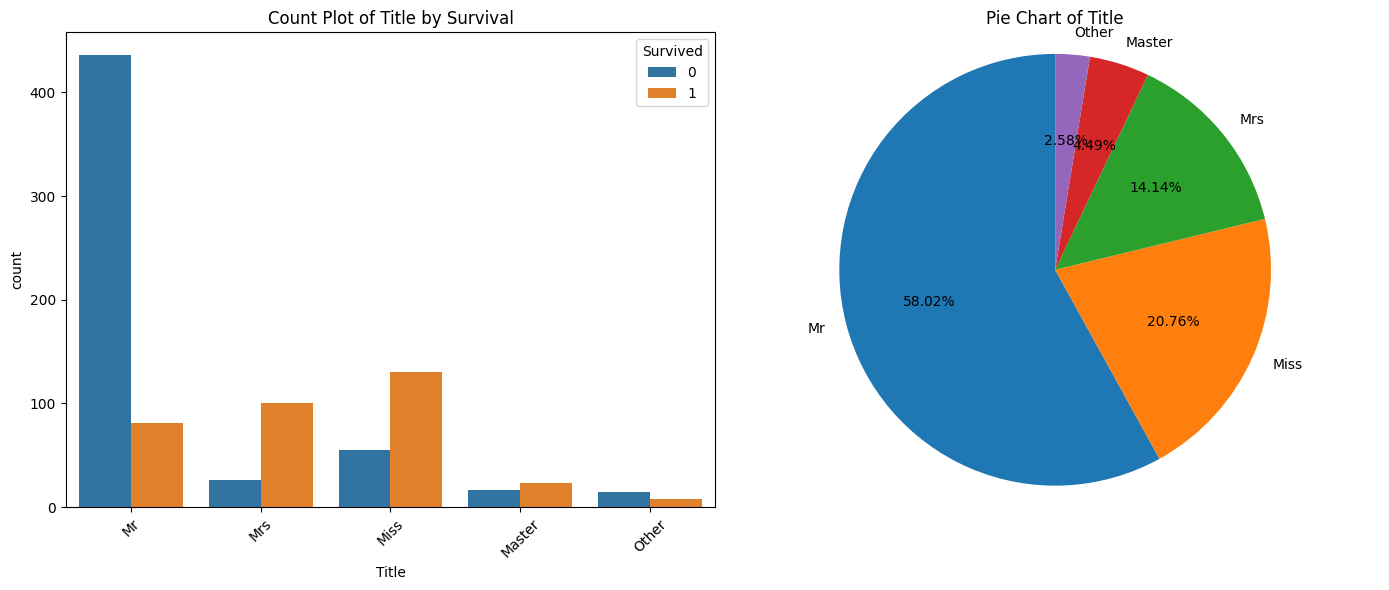

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted figure size

col = 'Title'  # Define the column name

# Count plot with 'Survived' as hue
sns.countplot(x=df[col], ax=axes[0],  hue=df['Survived'])  
axes[0].set_title(f"Count Plot of {col} by Survival")
axes[0].tick_params(axis='x', rotation=45)  # Rotate for readability
axes[0].legend(title="Survived")  # Add legend for clarity

# Pie chart
value_counts = df[col].value_counts()
axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', 
            startangle=90)
axes[1].set_title(f"Pie Chart of {col}")
axes[1].axis('equal')  # Ensures the pie chart is circular

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

- The count plot visualizes the relationship between the titles of individuals (e.g., Mrs, Miss, Master, Other) and their survival status (Survived: 0 or 1). 
-  "Mrs" is 14.14%, while for another category ("Miss"), it is 20.76%. This suggests that individuals with the title "Miss" had a higher number of onboard compared to "Mrs".
- The count of individuals with each title varies, with some titles having higher counts than others.

## Transforming Sibsp and Parch
- since Sibsp and parch can give overall family size we can use one column instead of two columns

### Creating a Family Column by Combining Sibling and Parent Child Column 

In [18]:
df['Family_size']=df['SibSp'] + df['Parch'] + 1

In [19]:
def family_size(number):
    if number==1:
        return "Alone"
    elif number>1 and number <5:
        return "Small"
    else:
        return "Large"

In [20]:
#creating a Family_size column
df['Family_size']=df['Family_size'].apply(family_size)

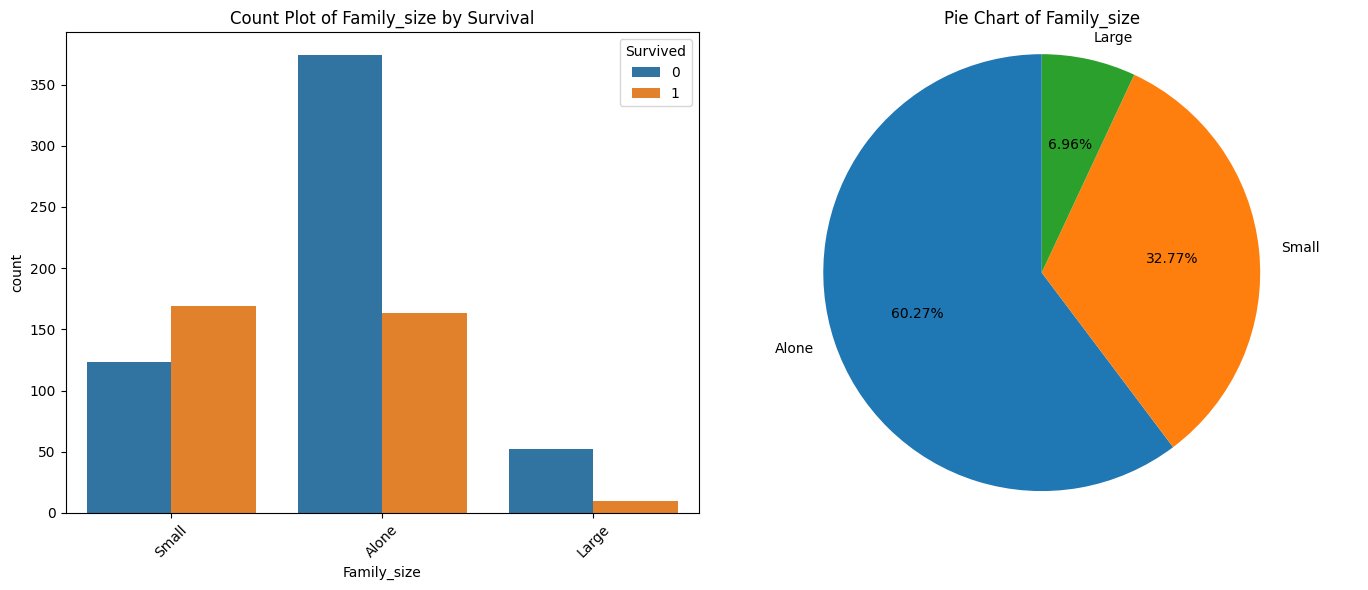

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted figure size

col = 'Family_size'  # Define the column name

# Count plot with 'Survived' as hue
sns.countplot(x=df[col], ax=axes[0],  hue=df['Survived'])  
axes[0].set_title(f"Count Plot of {col} by Survival")
axes[0].tick_params(axis='x', rotation=45)  # Rotate for readability
axes[0].legend(title="Survived")  # Add legend for clarity

# Pie chart
value_counts = df[col].value_counts()
axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', 
            startangle=90)
axes[1].set_title(f"Pie Chart of {col}")
axes[1].axis('equal')  # Ensures the pie chart is circular

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

- The visualization appears to analyze the relationship between family size and survival rates
- The data is segmented into different family sizes (Large, Small, Alone) and their corresponding survival rates.

## Survived with age group - Exploring different age groups

In [22]:
print("Percentage Survived in age ranges: ")
print("Age 0-18 (Below 18) =>", df[(df["Age"] < 18) & (df["Survived"] == 1)].shape[0]/len(df) *100)
print("Age 18-30 (Adult) => ", df[(df["Age"] >= 18) & (df["Age"] <= 30) & (df["Survived"] == 1)].shape[0]/len(df) *100)
print("Age 31-45 (Matured) => ", df[(df["Age"] > 30) & (df["Age"] <= 45) & (df["Survived"] == 1)].shape[0]/len(df) *100)
print("Age 46+ (Old) =>", df[(df["Age"] > 45) & (df["Survived"] == 1)].shape[0]/len(df) *100)


print("\n Percentage Not Survived in age ranges: ")
print("Age 0-18 (Below 18) =>", df[(df["Age"] < 18) & (df["Survived"] == 0)].shape[0]/len(df) *100)
print("Age 18-30 (Adult) => ", df[(df["Age"] >= 18) & (df["Age"] <= 30) & (df["Survived"] == 0)].shape[0]/len(df) *100)
print("Age 31-45 (Matured) => ", df[(df["Age"] > 30) & (df["Age"] <= 45) & (df["Survived"] == 0)].shape[0]/len(df) *100)
print("Age 46+ (Old) =>", df[(df["Age"] > 45) & (df["Survived"] == 0)].shape[0]/len(df) *100)

Percentage Survived in age ranges: 
Age 0-18 (Below 18) => 6.846240179573512
Age 18-30 (Adult) =>  17.62065095398429
Age 31-45 (Matured) =>  9.652076318742985
Age 46+ (Old) => 4.264870931537598

 Percentage Not Survived in age ranges: 
Age 0-18 (Below 18) => 5.836139169472503
Age 18-30 (Adult) =>  35.69023569023569
Age 31-45 (Matured) =>  13.019079685746352
Age 46+ (Old) => 7.07070707070707


### Feature Selection - Dropping unnecessary columns

In [23]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_size
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S,Mr,Small
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C,Mrs,Small
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S,Miss,Alone
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S,Mrs,Small
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S,Mr,Alone


In [39]:
# dropping uneccessary columns because they are transformed into other columns
df = df.drop(columns=['Name', 'SibSp', 'Parch'], errors='ignore')

In [25]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family_size
0,0,3,male,22,7.2500,S,Mr,Small
1,1,1,female,38,71.2833,C,Mrs,Small
2,1,3,female,26,7.9250,S,Miss,Alone
3,1,1,female,35,53.1000,S,Mrs,Small
4,0,3,male,35,8.0500,S,Mr,Alone


## COrrelation

In [26]:
corr = df[['Survived', 'Pclass','Age','Fare']].corr()

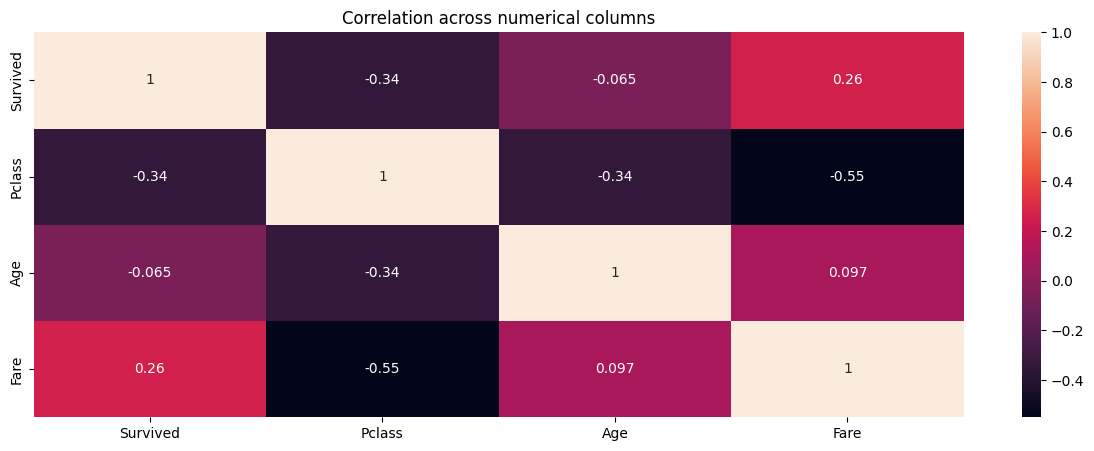

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
corrplot = sns.heatmap(data=corr, annot=True, ax=ax)
plt.title("Correlation across numerical columns")
plt.show()

- The numbers in this matrix likely represent correlation coefficients, indicating the strength and direction of relationships between these variables.
- The correlation between Pclass and Survived is -0.34, indicating a moderate negative relationship. This suggests that passengers in higher classes (lower Pclass values) had a higher survival rate.

## Creating Preprocessing Pipelines:
- Num Numerical Pipeline: scaling.
- Categorical Pipeline: Encodes categorical variables using OneHotEncoding (for nominal data) or Ordinal Encoding (for ordinal data).



In [28]:
# Numerical Pipeline: Scaling numerical features 
numerical_pipeline = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')),  # Imputes missing numerical values with the mean
    ('scaler', MinMaxScaler())                   # Scales features to a range
])

# Categorical Pipeline for One-Hot Encoding (Nominal Data)
onehot_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Apply OneHotEncoding
])

# Categorical Pipeline for Ordinal Encoding (Ordinal Data)
ordinal_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Ordinal Encoding
])


## Combining the Pipelines:
- Uses ColumnTransformer to apply the respective pipelines to numerical and categorical features.


In [29]:
num_features = ["Age", "Fare"]
onehot_features = ["Sex", "Embarked", "Title"]  # Example of nominal categories (unordered)
ordinal_features = ["Pclass", "Family_size"]  # Example of ordinal categories (ordered)

In [30]:
# Combining the numerical and categorical pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, num_features),
    ('onehot', onehot_pipeline, onehot_features),
    ('ordinal', ordinal_pipeline, ordinal_features) 
], remainder='passthrough')

## Creating the Full Pipeline:

- The preprocessing steps are integrated into the final modeling pipeline, allowing for streamlined training.


In [31]:
# Full Pipeline: Combining the preprocessor with a feature selector and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
    # ('feature_selection', SelectKBest(score_func=chi2, k=10)),  # Selecting the best 10 features based on chi-squared test
])

# Separating dependent and independent features

In [32]:
X = df.drop('Survived', axis=1)
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Family_size
0,3,male,22,7.2500,S,Mr,Small
1,1,female,38,71.2833,C,Mrs,Small
2,3,female,26,7.9250,S,Miss,Alone
3,1,female,35,53.1000,S,Mrs,Small
4,3,male,35,8.0500,S,Mr,Alone


In [33]:
y = df['Survived'].copy()

# Train-Test SPlit

In [34]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train

,Pclass,Sex,Age,Fare,Embarked,Title,Family_size
331,1,male,45,28.5000,S,Mr,Alone
733,2,male,23,13.0000,S,Mr,Alone
382,3,male,32,7.9250,S,Mr,Alone
704,3,male,26,7.8542,S,Mr,Small
813,3,female,6,31.2750,S,Miss,Large
...,...,...,...,...,...,...,...
106,3,female,21,7.6500,S,Miss,Alone
270,1,male,28,31.0000,S,Mr,Alone
860,3,male,41,14.1083,S,Mr,Small
435,1,female,14,120.0000,S,Miss,Small


# Fitting the pipeline

In [36]:
# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Pclass',
                                                   'Family_size'])]))])

In [37]:
# import pickle
# pickle.dump(pipeline, open('pipeline1.pkl','wb'))

In [38]:
# df.to_csv('feature_engineered.csv', index=False)